In [1]:
import torch
import numpy as np

In [2]:
data = [[1, 2], [3, 4]]
x_data = torch.tensor(data)

In [3]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

In [6]:
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.5653, 0.9835],
        [0.1940, 0.0732]]) 



In [7]:
tensor = torch.rand(3, 4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


In [8]:
# We move our tensor to the GPU if available
if torch.cuda.is_available():
  tensor = tensor.to('cuda')
  print(f"Device tensor is stored on: {tensor.device}")

In [9]:
tensor = torch.ones(4, 4)
tensor[:,1] = 0
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [10]:
print(tensor, "\n")
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


## Introduction to autograd

In [11]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)
data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/michele/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 15.9MB/s]


In [12]:
prediction = model(data) # forward pass


In [13]:
loss = (prediction - labels).sum()
loss.backward() # backward pass

In [14]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)


In [15]:
optim.step() #gradient descent


## Neural Networks

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, input):
        # Convolution layer C1: 1 input image channel, 6 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a Tensor with size (N, 6, 28, 28), where N is the size of the batch
        c1 = F.relu(self.conv1(input))
        # Subsampling layer S2: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 6, 14, 14) Tensor
        s2 = F.max_pool2d(c1, (2, 2))
        # Convolution layer C3: 6 input channels, 16 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a (N, 16, 10, 10) Tensor
        c3 = F.relu(self.conv2(s2))
        # Subsampling layer S4: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 16, 5, 5) Tensor
        s4 = F.max_pool2d(c3, 2)
        # Flatten operation: purely functional, outputs a (N, 400) Tensor
        s4 = torch.flatten(s4, 1)
        # Fully connected layer F5: (N, 400) Tensor input,
        # and outputs a (N, 120) Tensor, it uses RELU activation function
        f5 = F.relu(self.fc1(s4))
        # Fully connected layer F6: (N, 120) Tensor input,
        # and outputs a (N, 84) Tensor, it uses RELU activation function
        f6 = F.relu(self.fc2(f5))
        # Gaussian layer OUTPUT: (N, 84) Tensor input, and
        # outputs a (N, 10) Tensor
        output = self.fc3(f6)
        return output


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
params = list(net.parameters())
print(len(params))
print(params[2].size())  # conv2's .weight

10
torch.Size([16, 6, 5, 5])


In [22]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.0127, -0.0566, -0.0886,  0.0839,  0.0835,  0.0775, -0.1858, -0.0229,
          0.0303,  0.0690]], grad_fn=<AddmmBackward0>)


In [23]:
net.zero_grad()
out.backward(torch.randn(1, 10))

### Computing loss

In [24]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.2115, grad_fn=<MseLossBackward0>)


2)

In [25]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.0861, grad_fn=<MseLossBackward0>)


In [37]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU
print(loss.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)

()


In [38]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([ 0.0039, -0.0016,  0.0194, -0.0081,  0.0022,  0.0040])


In [39]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

# Classifying CIFAR

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:


batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


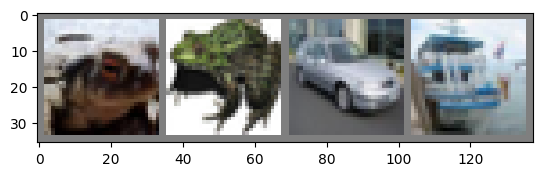

frog  frog  car   ship 


In [42]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


#net = Net()

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')



[1,  2000] loss: 2.224
[1,  4000] loss: 1.943
[1,  6000] loss: 1.742
[1,  8000] loss: 1.631
[1, 10000] loss: 1.565
[1, 12000] loss: 1.497
[2,  2000] loss: 1.423
[2,  4000] loss: 1.394
[2,  6000] loss: 1.355
[2,  8000] loss: 1.350
[2, 10000] loss: 1.323
[2, 12000] loss: 1.316
Finished Training


In [46]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [47]:
outputs = net(images)

In [48]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  truck frog  car   ship 


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [13]:

def test_accuracy(net, testloader):

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [14]:
# do the above with a function that retuns the train lossess and tests the model on every epoch and returns the accuracies too

def train_model(net, trainloader, testloader, criterion, optimizer, epochs=2):
    train_losses = []
    test_accuracies = []
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0

        running_epoch_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            running_epoch_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

        train_losses.append(running_epoch_loss / len(trainloader))
        acc = test_accuracy(net, testloader)

        print(f'Validation accuracy after epoch {epoch + 1}: {acc}')
        test_accuracies.append(acc)
    print('Finished Training')
    return train_losses, test_accuracies

In [50]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 59.6 %
Accuracy for class: car   is 69.1 %
Accuracy for class: bird  is 56.2 %
Accuracy for class: cat   is 49.8 %
Accuracy for class: deer  is 21.6 %
Accuracy for class: dog   is 39.6 %
Accuracy for class: frog  is 55.3 %
Accuracy for class: horse is 53.3 %
Accuracy for class: ship  is 79.1 %
Accuracy for class: truck is 51.5 %


# Optimization 

In [12]:
import torch.optim as optim
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, nesterov=True)

train_losses, test_accuracies = train_model(net, trainloader, testloader, criterion, optimizer, epochs=4)

[1,  2000] loss: 2.141
[1,  4000] loss: 1.819
[1,  6000] loss: 1.658
[1,  8000] loss: 1.549
[1, 10000] loss: 1.488
[1, 12000] loss: 1.428
Validation accuracy after epoch 1: 49.37
[2,  2000] loss: 1.390
[2,  4000] loss: 1.347
[2,  6000] loss: 1.309
[2,  8000] loss: 1.302
[2, 10000] loss: 1.288
[2, 12000] loss: 1.262
Validation accuracy after epoch 2: 56.02
[3,  2000] loss: 1.203
[3,  4000] loss: 1.200
[3,  6000] loss: 1.187
[3,  8000] loss: 1.179
[3, 10000] loss: 1.171
[3, 12000] loss: 1.175
Validation accuracy after epoch 3: 59.56
[4,  2000] loss: 1.091
[4,  4000] loss: 1.093
[4,  6000] loss: 1.109
[4,  8000] loss: 1.112
[4, 10000] loss: 1.101
[4, 12000] loss: 1.092
Validation accuracy after epoch 4: 61.05
Finished Training


In [19]:
train_losses

[721.4599139392376, 631.4230667054653, 587.6961565203965, 548.3298990279436]

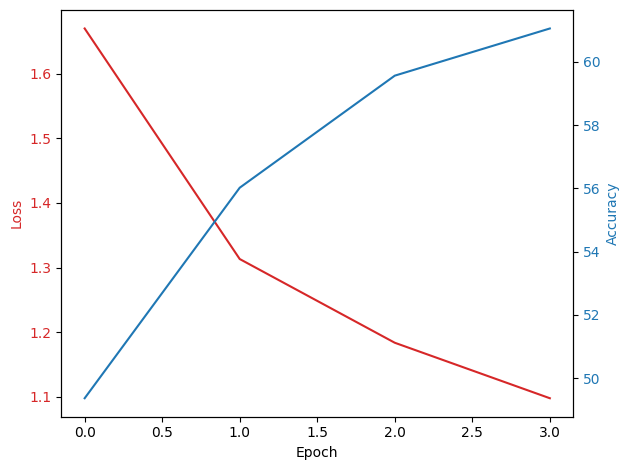

In [18]:
# plotting results in a fancy way in the same graph

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

color = 'tab:red'

ax1.set_xlabel('Epoch')

ax1.set_ylabel('Loss', color=color)

ax1.plot(train_losses, color=color)

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'

ax2.set_ylabel('Accuracy', color=color)

ax2.plot(test_accuracies, color=color)

ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

plt.show()

# plotting results in a fancy way in the same graph




In [29]:
batch_size = 2

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       
                                        download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, nesterov=True)

train_losses_b2_001_09_true, test_accuracies_b2_001_09_true = train_model(net, trainloader, testloader, criterion, optimizer, epochs=4)

[1,  2000] loss: 2.237
[1,  4000] loss: 1.951
[1,  6000] loss: 1.783
[1,  8000] loss: 1.680
[1, 10000] loss: 1.635
[1, 12000] loss: 1.628
[1, 14000] loss: 1.543
[1, 16000] loss: 1.527
[1, 18000] loss: 1.500
[1, 20000] loss: 1.491
[1, 22000] loss: 1.500
[1, 24000] loss: 1.437
Validation accuracy after epoch 1: 49.98
[2,  2000] loss: 1.374
[2,  4000] loss: 1.361
[2,  6000] loss: 1.359
[2,  8000] loss: 1.374
[2, 10000] loss: 1.358
[2, 12000] loss: 1.303
[2, 14000] loss: 1.327
[2, 16000] loss: 1.326
[2, 18000] loss: 1.312
[2, 20000] loss: 1.323
[2, 22000] loss: 1.294
[2, 24000] loss: 1.309
Validation accuracy after epoch 2: 55.32
[3,  2000] loss: 1.213
[3,  4000] loss: 1.211
[3,  6000] loss: 1.211
[3,  8000] loss: 1.231
[3, 10000] loss: 1.238
[3, 12000] loss: 1.223
[3, 14000] loss: 1.228
[3, 16000] loss: 1.228
[3, 18000] loss: 1.217
[3, 20000] loss: 1.200
[3, 22000] loss: 1.198
[3, 24000] loss: 1.213
Validation accuracy after epoch 3: 57.96
[4,  2000] loss: 1.108
[4,  4000] loss: 1.150
[4,

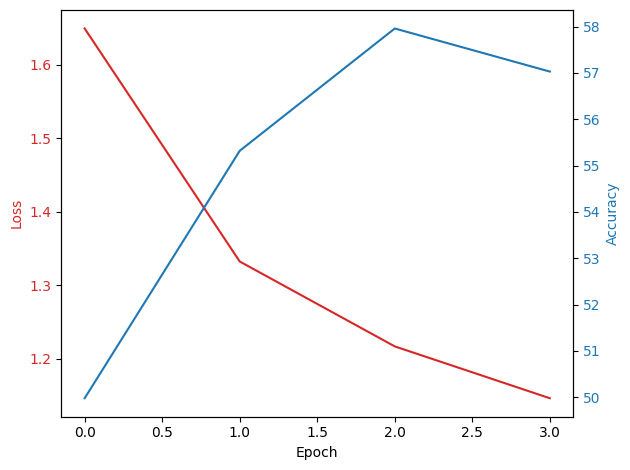

In [32]:
# plotting results in a fancy way in the same graph

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

color = 'tab:red'

ax1.set_xlabel('Epoch')

ax1.set_ylabel('Loss', color=color)

ax1.plot(train_losses_b2_001_09_true, color=color)

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'

ax2.set_ylabel('Accuracy', color=color)

ax2.plot(test_accuracies_b2_001_09_true, color=color)

ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

plt.show()

# plotting results in a fancy way in the same graph




In [23]:
batch_size = 10

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       
                                        download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, nesterov=True)

train_losses, test_accuracies = train_model(net, trainloader, testloader, criterion, optimizer, epochs=4)

[1,  2000] loss: 2.210
[1,  4000] loss: 1.786
Validation accuracy after epoch 1: 42.82
[2,  2000] loss: 1.501
[2,  4000] loss: 1.397
Validation accuracy after epoch 2: 51.96
[3,  2000] loss: 1.285
[3,  4000] loss: 1.252
Validation accuracy after epoch 3: 56.77
[4,  2000] loss: 1.165
[4,  4000] loss: 1.146
Validation accuracy after epoch 4: 59.46
Finished Training


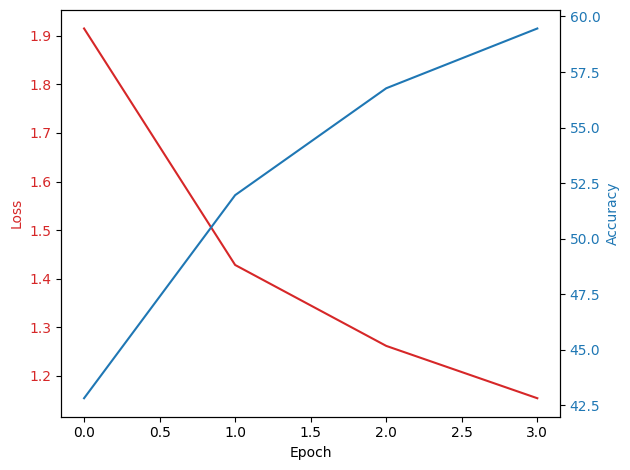

In [28]:
# display the results
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'

ax1.set_xlabel('Epoch')

ax1.set_ylabel('Loss', color=color)

ax1.plot(train_losses, color=color)

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'

ax2.set_ylabel('Accuracy', color=color)

ax2.plot(test_accuracies, color=color)

ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

plt.show()

# Further optimization

In [2]:
# using weight decay

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       
                                        download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [9]:


net = Net()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

train_losses_b4_001_09_wd001, test_accuracies_b4_001_09_wd001 = train_model(net, trainloader, testloader, criterion, optimizer, epochs=4)

KeyboardInterrupt: 

In [ ]:
# function to plot the results

import matplotlib.pyplot as plt

def plot_results(train_losses, test_accuracies):



    fig, ax1 = plt.subplots()
    
    color = 'tab:red'

    ax1.set_xlabel('Epoch')

    ax1.set_ylabel('Loss', color=color)

    ax1.plot(train_losses, color=color)

    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()

    color = 'tab:blue'

    ax2.set_ylabel('Accuracy', color=color)

    ax2.plot(test_accuracies, color=color)

    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()

    plt.show()

In [19]:
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       
                                        download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       
                                        download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

net = Net()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

train_losses_b4_001_09_wd0001, test_accuracies_b4_001_09_wd0001 = train_model(net, trainloader, testloader, criterion, optimizer, epochs=4)

Files already downloaded and verified
Files already downloaded and verified
[1,  2000] loss: 2.188
[1,  4000] loss: 1.805
[1,  6000] loss: 1.659
[1,  8000] loss: 1.564
[1, 10000] loss: 1.525
[1, 12000] loss: 1.492
Validation accuracy after epoch 1: 48.97
[2,  2000] loss: 1.423
[2,  4000] loss: 1.380
[2,  6000] loss: 1.348
[2,  8000] loss: 1.350
[2, 10000] loss: 1.324
[2, 12000] loss: 1.287
Validation accuracy after epoch 2: 54.26
[3,  2000] loss: 1.238
[3,  4000] loss: 1.224
[3,  6000] loss: 1.221
[3,  8000] loss: 1.200
[3, 10000] loss: 1.226
[3, 12000] loss: 1.174
Validation accuracy after epoch 3: 57.68
[4,  2000] loss: 1.126
[4,  4000] loss: 1.142
[4,  6000] loss: 1.118
[4,  8000] loss: 1.125
[4, 10000] loss: 1.117
[4, 12000] loss: 1.117
Validation accuracy after epoch 4: 58.63
Finished Training


### Using batch mormalization

In [ ]:
# adding batch normalization

import torch.nn as nn

import torch
import torch.nn as nn
import torch.nn.functional as F


class BatchNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)  # BatchNorm after first conv layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)  # BatchNorm after second conv layer
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)  # BatchNorm after first fully connected layer
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)  # BatchNorm after second fully connected layer
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Apply BatchNorm after conv1
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Apply BatchNorm after conv2
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.bn3(self.fc1(x)))  # Apply BatchNorm after fc1
        x = F.relu(self.bn4(self.fc2(x)))  # Apply BatchNorm after fc2
        x = self.fc3(x)
        return x


In [10]:
# training the model

batch_net = Net()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(batch_net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

train_losses_b4_001_09_wd0001, test_accuracies_b4_001_09_wd0001 = train_model(batch_net, trainloader, testloader, criterion, optimizer, epochs=4)



[1,  2000] loss: 2.218
[1,  4000] loss: 1.938
[1,  6000] loss: 1.720
[1,  8000] loss: 1.608
[1, 10000] loss: 1.532
[1, 12000] loss: 1.486
Validation accuracy after epoch 1: 48.54
[2,  2000] loss: 1.404
[2,  4000] loss: 1.380
[2,  6000] loss: 1.375
[2,  8000] loss: 1.326
[2, 10000] loss: 1.323
[2, 12000] loss: 1.304
Validation accuracy after epoch 2: 52.04
[3,  2000] loss: 1.220
[3,  4000] loss: 1.230
[3,  6000] loss: 1.215
[3,  8000] loss: 1.189
[3, 10000] loss: 1.204
[3, 12000] loss: 1.207
Validation accuracy after epoch 3: 56.53
[4,  2000] loss: 1.114
[4,  4000] loss: 1.137
[4,  6000] loss: 1.118
[4,  8000] loss: 1.128
[4, 10000] loss: 1.130
[4, 12000] loss: 1.135
Validation accuracy after epoch 4: 59.74
Finished Training


In [11]:
batch_net = Net()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(batch_net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

train_losses_b4_001_09_wd0001, test_accuracies_b4_001_09_wd0001 = train_model(batch_net, trainloader, testloader, criterion, optimizer, epochs=8)

[1,  2000] loss: 2.209
[1,  4000] loss: 1.896
[1,  6000] loss: 1.716
[1,  8000] loss: 1.607
[1, 10000] loss: 1.557
[1, 12000] loss: 1.496
Validation accuracy after epoch 1: 47.14
[2,  2000] loss: 1.433
[2,  4000] loss: 1.422
[2,  6000] loss: 1.386
[2,  8000] loss: 1.344
[2, 10000] loss: 1.323
[2, 12000] loss: 1.309
Validation accuracy after epoch 2: 52.31
[3,  2000] loss: 1.229
[3,  4000] loss: 1.227
[3,  6000] loss: 1.244
[3,  8000] loss: 1.234
[3, 10000] loss: 1.209
[3, 12000] loss: 1.214
Validation accuracy after epoch 3: 57.9
[4,  2000] loss: 1.140
[4,  4000] loss: 1.123
[4,  6000] loss: 1.141
[4,  8000] loss: 1.146
[4, 10000] loss: 1.140
[4, 12000] loss: 1.119
Validation accuracy after epoch 4: 59.91
[5,  2000] loss: 1.038
[5,  4000] loss: 1.078
[5,  6000] loss: 1.063
[5,  8000] loss: 1.060
[5, 10000] loss: 1.081
[5, 12000] loss: 1.085
Validation accuracy after epoch 5: 60.34
[6,  2000] loss: 1.002
[6,  4000] loss: 1.006
[6,  6000] loss: 1.016
[6,  8000] loss: 1.017
[6, 10000] los